Can orthopedic patients be classified as healthy/unhealthy based on their biomechanical features? What features are most important and crucial in determining their health status? Let's find out!

This dataset comes from the UCI Machine Learning Repository.

Loading relevant libraries and importing the data:

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

ortho = pd.read_csv("C:\Python\Machine Learning\OrthoPatients\column_2C_weka.csv")


print('No missing records: {0}'.format(len(ortho.dropna()) == len(ortho))) ##Checking to see whether we have any missing records

ortho.head()

No missing records: True


,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Abnormal


#### Agenda: 

a) The data appears to be sparkling clean, so we're going to jump right to some good old exploratory data analysis.

b) Given that we wish to predict the health status of a person based on all the numerical biomechanical features, this becomes an interesting classification problem. Since we have few observations (~300 records), it does not make sense to use super flexible machine learning methods. Instead, we will stick to using kNN and Logistic Regression. We also attempt to identify the principal features in the dataset using a dimensionality reduction method.

Let's rename the columns since they're rather verbose.

In [20]:
ortho.columns = ['pel_inc', 'pel_tilt', 'lumb_lord', 'sacr_slope', 'pel_rad', 'deg_spondy', 'class']
ortho.head()

,pel_inc,pel_tilt,lumb_lord,sacr_slope,pel_rad,deg_spondy,class
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Abnormal


#### Dataviz time!

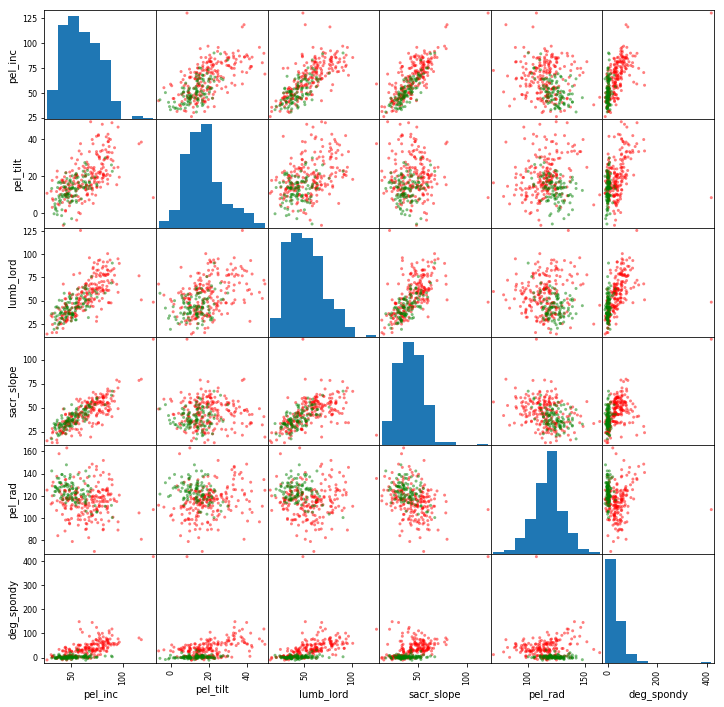

In [45]:
color_list = ['red' if i == 'Abnormal' else 'green' for i in ortho.loc[:,'class']] #Assigning colors to classes

pd.plotting.scatter_matrix(ortho, c = color_list, figsize = (12,12));

Observations: Okay, there's a lot going on here. Pelvic_Incidence appears to be highly correlated with all features except Pelvic_Radius and Degree_Spondylolisthesis. This is vital from a modeling perspective. Pelvic_Radius seems to lack correlation with all features. 

#### kNN

kNN, or k-Nearest Neighbors is a neighbor-based classification method that labels a data point based on the class of the neighbors of the data point of interest. For example, if we set k to be 2, we would be able to classify a data point 'A' (the class would be Abnormal or Normal in the present case) based on the classes of the two neighbors that are closest to A.

We shall first split the dataset into train and test sets. We train our algorithms on the training set and we test out the efficiency of our model on the test test.

In [89]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
x = ortho.loc[:,ortho.columns != 'class']
y = ortho.loc[:, 'class']
# Splitting x and y data into train and test parts
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 1)

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(x_train, y_train)
knn.predict(x_test)

print('Accuracy with k = 5 neighbors is {0}'.format(round(knn.score(x_test,y_test),3)))


Accuracy with k = 5 neighbors is 0.872


We get to the classical kNN question - how many neighbors should the algorithm consider for making a good decision? We could iterate over prediction accuracies to see the value of k that yields least test error. Let's try to see the right amount of model complexity for kNN in the present context.



Value of k for which we obtain highest test accuracy is: 15


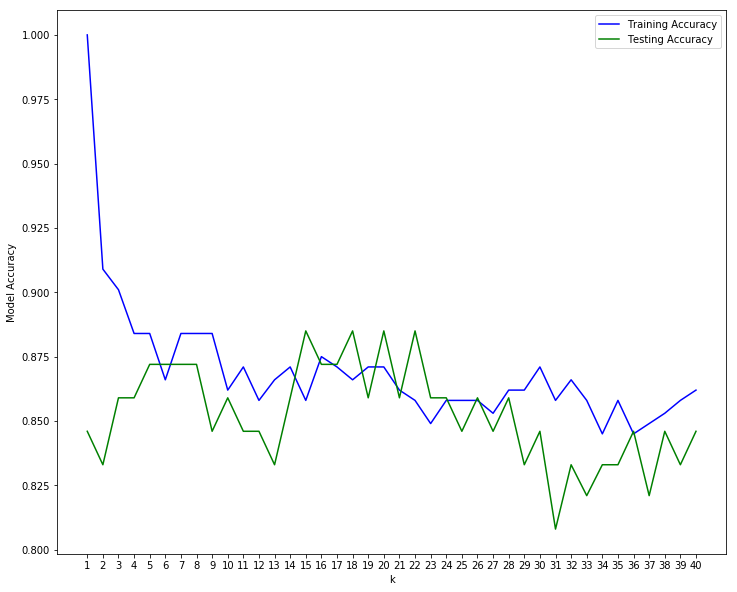

In [119]:
k_vals = np.arange(1, 41)
train_scores = []
test_scores = []

for i, k in enumerate(k_vals):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(x_train, y_train)
    knn.predict(x_test)
    train_scores.append(round(knn.score(x_train, y_train),3))
    test_scores.append(round(knn.score(x_test, y_test),3))

plt.figure(figsize = (12,10))
plt.plot(k_vals, train_scores, c = 'blue', label = 'Training Accuracy')
plt.plot(k_vals, test_scores, c = 'green', label = 'Testing Accuracy')
plt.xlabel('k')
plt.ylabel('Model Accuracy')
plt.xticks(k_vals)
plt.legend();

print('Value of k for which we obtain highest test accuracy is: {0}'.format(1 + test_scores.index(np.max(test_scores))))

So we managed to naively fit a kNN model to the data. Are all the features 'necessary' for our model though?

Since we have 6 features to make predictions about the class and about 300 observations of both classes, we could think about reducing the number of features in our model. This is necessary to de-jinx the so called "curse of dimensionality". We apply such a dimensionality reduction algorithm to extract the key features (rather a combination of key features) from our feature space.

#### Feature Extraction with Principal Component Analysis

Percentage of variation explained by the Principal Components is: 86.7


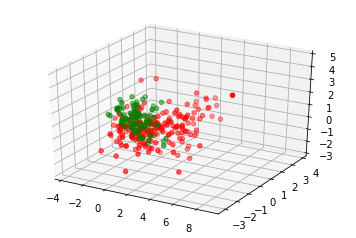

In [221]:
## Preprocessing:

from sklearn.preprocessing import StandardScaler
features = ortho.loc[:, ortho.columns != 'class'].values
ortho_scaled_features = StandardScaler().fit_transform(features)

## Applying PCA:

from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
principalComponents = pca.fit_transform(ortho_scaled_features)
principalComponents.shape
principalComponents_df = pd.DataFrame(principalComponents, columns = ['PC1', 'PC2', 'PC3'])
principalComponents_df

target = ortho.loc[:,'class']
target = pd.DataFrame(target, columns = ['class'])
pca_df = principalComponents_df.join(target)
pca_df

print('Percentage of variation explained by the Principal Components is: {0}'.format(round(sum(pca.explained_variance_ratio_),3)*100))

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
figsize = (20,20)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c = color_list);


We managed to capture 87% of the variation using three principal components alone (although not shown, if another Principal Component were to be added, we would only get an additional variance explanation of about 0.07%). 

Which of the features contribute most to the result we see in the PCA? Recall that one of our intentions was to evaluate the most important biomechanical features that contributed to abnormality. The pca.components_ method lets us grasp the relative loadings of each feature in the principal components.

In [263]:
comps = pca.components_     ##Feature loads to each component
weights = pca.explained_variance_ratio_  ##weights of each Principal Component
loads = []
for i in range(3):
    loads.append(comps[i]*weights[i])
fin_wts = loads[0] + loads[1] + loads[2]
feature_weights = np.vstack([fin_wts, np.arange(1,7)])

feature_weights[:,np.argsort(feature_weights[0,:])]

array([[0.14159955, 0.19779358, 0.20805011, 0.27686918, 0.2855599 ,
        0.29616407],
       [5.        , 2.        , 4.        , 1.        , 3.        ,
        6.        ]])

The 1st, 3rd and 6th features appear to be the most important features in the dataset. These features are: Pelvic_Incidence, Lumbar_Lordosis_Angle and Degree_Spondylolisthesis. We create the dataset imp_ortho that contains the important features with the target variable below.

     pel_inc  lumb_lord  deg_spondy     class
0  63.027818  39.609117   -0.254400  Abnormal
1  39.056951  25.015378    4.564259  Abnormal
2  68.832021  50.092194   -3.530317  Abnormal
3  69.297008  44.311238   11.211523  Abnormal
4  49.712859  28.317406    7.918501  Abnormal


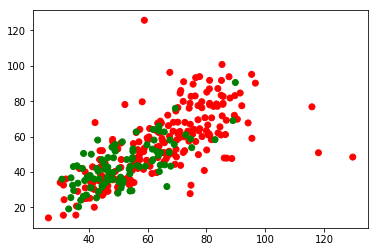

In [264]:
imp_ortho = ortho.iloc[:,[0,2,5,6]]
print(imp_ortho.head())
plt.scatter(imp_ortho['pel_inc'], imp_ortho['lumb_lord'], c = color_list)

#### Logistic Regression

Logistic Regression is a powerful binary classifier that belongs to the family of the classical parametric generalized linear models. It has a linear decision boundary. Let's try to implement it!

In [294]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

x_features = imp_ortho.iloc[:,[0,1,2]]
y_features = imp_ortho.iloc[:,3]

x_train, x_test, y_train, y_test = train_test_split(x_features, y_features, test_size = 0.3, random_state = 1)
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)
score = logreg.score(x_test, y_test)

print('Test Set Accuracy Percentage from Logistic Regression is: {0}'.format(100*round(score,3)))

from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix
sens = cf_matrix[1,1]/sum(cf_matrix[1,:])
spec = cf_matrix[0,0]/sum(cf_matrix[0,:])
print('Sensitivity of Model is: {0}, Specificity of Model is: {1}'.format(round(sens,3), round(spec,3)))

Test Set Accuracy Percentage from Logistic Regression is: 86.0
Sensitivity of Model is: 0.889, Specificity of Model is: 0.848


### Conclusions:

1) We used PCA to determine the most important features in the dataset. Pelvic_Incidence, Lumbar_Lordosis_Angle and Degree_Spondylolisthesis are the most important biomechanical features that determine a person's vertebral health.

2) The logistic regression model built with the three chosen features offers a fairly high sensitivity and specificity. Further hyperparameter tuning may be done to view the effects of choosing different thresholds.